# Zadanie 4: obliczenia ewolucyjne

Termin realizacji: 5 maja 2025

Zadanie do oddania przez MS Teams. Do oddania: kod oraz krótkie sprawozdanie w PDF (można na przykład przy użyciu `quarto render notebook.ipynb --to pdf`).

## Na 3.0

Do realizacji:

1. Zmodyfikuj przykład "iterative method" z notatnika `tsp_lazy_constraints.ipynb` z poprzednich zajęć tak, aby rozwiązywał [problem podróżującego konsumenta](https://en.wikipedia.org/wiki/Traveling_purchaser_problem). Przykładowe problemy generuje poniższa funkcja `generate_random_tpp`. Przyjmij, że wszystkie miasta muszą być odwiedzone niezależnie od tego czy dokonany tam będzie zakup czy też nie. W rozwiązaniu wypisz w którym mieście kupione będą poszczególne przedmioty oraz narysuj trasę.
2. Zmodyfikuj analogicznie kod z notatnika `tsp-genetic.ipynb` tak aby rozwiązywał ten sam problem. Porównaj wydajność (czas obliczeń i wartość funkcji kosztu) dla dziewięciu losowych problemów, po trzy dla rozmiarów (n=50, k=20), (n=50, k=50) oraz (n=100, k=100). Dobierz parametry algorytmu genetycznego tak, aby czas działania nie przekraczał w żadnym przypadku minuty.

## Na 4.0

Do realizacji:

1. Punkty z zadania na 3.0.
2. Zaimplementuj dodatkowo [krzyżowanie PMX](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#Partially_mapped_crossover_(PMX)) i porównaj wydajność z tym opartym o inwersję permutacji.

## Na 5.0

Do realizacji:

1. Punkty z zadania na 4.0.
2. Zmodyfikuj problem tak, aby konsument nie musiał odwiedzać miast w których niczego nie kupuje.
3. Dodaj dodatkowo do porównania zmodyfikowany dla problemu podróżującego konsumenta przykład "lazy constraints" z notatnika `tsp_lazy_constraints.ipynb`.


In [25]:
using JuMP
import GLPK
import Random
import Plots
using MathOptInterface
const MOI = MathOptInterface

function generate_random_tpp(n, k; random_seed = 1)
    rng = Random.MersenneTwister(random_seed)
    # distance matrix
    X = 100 * rand(rng, n)
    Y = 100 * rand(rng, n)
    d = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:n, j in 1:n]

    cost_item_city = 50 .+ 100 .* rand(rng, k, n) # cost_item_city[num_item, num_city]

    return X, Y, d, cost_item_city
end

generate_random_tpp (generic function with 1 method)

# Zadania na 3.0, Część I


In [8]:
function build_tpp_model(d, cost_item_city, n, k)
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @variable(model, z[1:k, 1:n], Bin)

    @objective(model, Min, sum(d .* x) / 2 + sum(cost_item_city .* z))

    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)

    @constraint(model, [i in 1:k], sum(z[i, j] for j in 1:n) == 1)

    return model
end

build_tpp_model (generic function with 1 method)

In [11]:
function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

function subtour(edges::Vector{Tuple{Int,Int}}, n)
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors = [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end

subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

function plot_tour(X, Y, x)
    plot = Plots.plot()
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    return plot
end

plot_tour (generic function with 1 method)

Found cycle of length 3
Found cycle of length 10
Found cycle of length 3
Found cycle of length 3
\n=== ZAKUPY ===
Produkt 1 kupiony w mieście 46
Produkt 2 kupiony w mieście 33
Produkt 3 kupiony w mieście 41
Produkt 4 kupiony w mieście 25
Produkt 5 kupiony w mieście 13
Produkt 6 kupiony w mieście 16
Produkt 7 kupiony w mieście 16
Produkt 8 kupiony w mieście 16
Produkt 9 kupiony w mieście 6
Produkt 10 kupiony w mieście 19
Produkt 11 kupiony w mieście 2
Produkt 12 kupiony w mieście 4
Produkt 13 kupiony w mieście 4
Produkt 14 kupiony w mieście 40
Produkt 15 kupiony w mieście 25
Produkt 16 kupiony w mieście 13
Produkt 17 kupiony w mieście 22
Produkt 18 kupiony w mieście 7
Produkt 19 kupiony w mieście 14
Produkt 20 kupiony w mieście 6


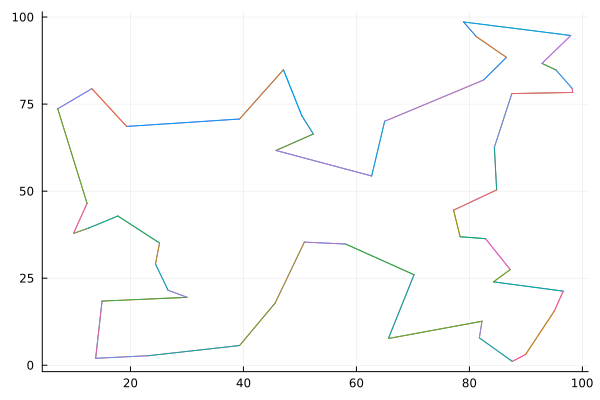

In [12]:
n, k = 50, 20
X, Y, d, cost_item_city = generate_random_tpp(n, k)
model = build_tpp_model(d, cost_item_city, n, k)

optimize!(model)
cycle = subtour(model[:x])
while 1 < length(cycle) < n
    println("Found cycle of length $(length(cycle))")
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    @constraint(model, sum(model[:x][i, j] for (i, j) in S) <= length(cycle) - 1)
    optimize!(model)
    cycle = subtour(model[:x])
end

# ====== WYNIKI ======
println("\\n=== ZAKUPY ===")
for i in 1:k
    for j in 1:n
        if value(model[:z][i, j]) > 0.5
            println("Produkt $i kupiony w mieście $j")
        end
    end
end

# ====== WIZUALIZACJA ======
plot_tour(X, Y, value.(model[:x]))

# Zadania na 3.0, Część II

In [20]:
using Random: AbstractRNG
using Evolutionary

n, k = 50, 20
X, Y, d, cost_item_city = generate_random_tpp(n, k)


([9.913970137863682, 70.19797138879542, 50.3261785841856, 87.58412053070398, 95.34654118744876, 50.7810571056071, 78.97511635624403, 7.125413261100788, 13.837807897217225, 39.31891799217675  …  47.07715605583087, 45.74787799446105, 39.31968187864505, 95.05129878297356, 78.35752622358207, 64.99869009136225, 13.167067492229867, 12.318877197601253, 19.319307029658294, 92.85029082227491], [37.858565883918295, 25.984947956264225, 71.67867297426689, 1.0898739765043075, 84.7785926801192, 35.36099955711283, 98.58458165854893, 73.65713555150472, 1.992039852101013, 70.72355934304049  …  84.87369607977678, 61.680928138712, 5.665730912653899, 15.622563304879634, 36.90767228785501, 70.07597765092129, 79.43901471209098, 46.482254570311675, 68.59072330642508, 86.69884288310024], [0.0 61.44219730376061 … 32.13916398865862 96.24866724284715; 61.44219730376061 0.0 … 66.3618156785821 64.80204173406327; … ; 32.13916398865862 66.3618156785821 … 0.0 75.72786522881266; 96.24866724284715 64.80204173406327 … 7

In [21]:
function has_subtour(perm::Vector)
    c = 1
    for i in 1:(length(perm)-1)
        c = perm[c]
        if c == 1
            return true
        end
    end
    return false
end

function mutate_swap(recombinant::AbstractVector; rng::AbstractRNG=Random.default_rng())
    N = length(recombinant)
    a = true
    while a || has_subtour(recombinant)
        i, j = rand(rng, 1:N), rand(rng, 1:N)
        recombinant[i], recombinant[j] = recombinant[j], recombinant[i]
        a = false
    end
    return recombinant
end

function perm_to_inv(perm::Vector)
    N = length(perm)
    inv = zeros(Int, N)
    for i in 1:N
        m = 1
        while perm[m] != i
            if perm[m] > i
                inv[i] += 1
            end
            m += 1
        end
    end
    return inv
end

function inv_to_perm(inv::Vector)
    N = length(inv)
    pos = zeros(Int, N)
    for i in N:-1:1
        for m in (i+1):N
            if pos[m] >= inv[i] + 1
                pos[m] += 1
            end
        end
        pos[i] = inv[i] + 1
    end
    perm = zeros(Int, N)
    for i in 1:N
        perm[pos[i]] = i
    end
    return perm
end

inv_to_perm (generic function with 1 method)

In [22]:
function recombine_tsp(v1::T, v2::T; rng::AbstractRNG=Random.default_rng()) where {T <: AbstractVector}
    N = length(v1)
    i1 = perm_to_inv(v1)
    i2 = perm_to_inv(v2)
    crossover_point = rand(2:(N-1))
    i1c = vcat(i1[1:crossover_point], i2[(crossover_point+1):N])
    i2c = vcat(i2[1:crossover_point], i1[(crossover_point+1):N])
    return inv_to_perm(i1c), inv_to_perm(i2c)
end

x0 = collect(1:n)



50-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 42
 43
 44
 45
 46
 47
 48
 49
 50

In [23]:
function cost(x)
    dist = 0.0
    for i in 1:(length(x) - 1)
        dist += d[x[i], x[i+1]]
    end
    dist += d[x[end], x[1]]  # powrót do startu

    # koszt zakupów - wybieramy najtańsze miasta dla każdego produktu
    purchase_cost = sum([minimum(cost_item_city[i, :]) for i in 1:k])

    return dist + purchase_cost
end

println("Initial cost: ", cost(x0))

Initial cost: 3504.6196624639356


Total cost: 2420.148050639967
Produkt 1 kupiony w mieście 46
Produkt 2 kupiony w mieście 33
Produkt 3 kupiony w mieście 41
Produkt 4 kupiony w mieście 25
Produkt 5 kupiony w mieście 13
Produkt 6 kupiony w mieście 16
Produkt 7 kupiony w mieście 16
Produkt 8 kupiony w mieście 16
Produkt 9 kupiony w mieście 6
Produkt 10 kupiony w mieście 19
Produkt 11 kupiony w mieście 2
Produkt 12 kupiony w mieście 4
Produkt 13 kupiony w mieście 4
Produkt 14 kupiony w mieście 40
Produkt 15 kupiony w mieście 25
Produkt 16 kupiony w mieście 13
Produkt 17 kupiony w mieście 22
Produkt 18 kupiony w mieście 7
Produkt 19 kupiony w mieście 14
Produkt 20 kupiony w mieście 6


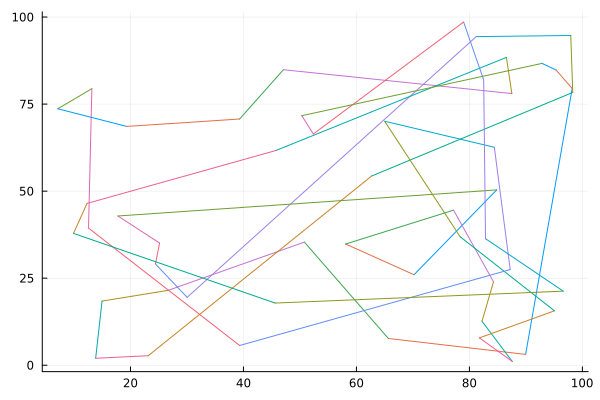

In [33]:
using Plots

x_sol = Evolutionary.optimize(
    cost,
    x0,
    GA(; populationSize=300, crossover=recombine_tsp, mutation=mutate_swap, epsilon=0.01, crossoverRate=0.9),
    Evolutionary.Options(; iterations=1000)
)

solution = x_sol.minimizer
println("Total cost: ", cost(solution))

# === OUTPUT zakupów ===
for i in 1:k
    best_city = argmin(cost_item_city[i, :])
    println("Produkt $i kupiony w mieście $best_city")
end

# === PLOT ===
function plot_tour(X, Y, route)
    plot = Plots.plot()  # nowy pusty wykres
    for i in 1:length(route)
        from = route[i]
        to = route[mod1(i+1, length(route))]  # trasa zamknięta
        Plots.plot!([X[from], X[to]], [Y[from], Y[to]]; legend=false)
    end
    return plot
end


plot_tour(X, Y, solution)